# Apply PDE-FIND algorithm to find the underlying PDE using sparse regression. 

The solar wind motion can be described as the fluid momentum equation in corotating frame of reference:
	
$$
-\Omega_{rot} \frac{\partial v}{\partial \phi} + (v \cdot \nabla)v = \frac{1}{\rho} \nabla P - \frac{G M_{s}}{r^2}e_{r}
$$

By neglecting pressure gradient and gravity terms, the fluid momentum equation reduces to the inviscid Burgers' equation.

$$
\frac{\partial v_{r}}{\partial \phi} = \frac{1}{\Omega_{rot}} v_{r} \frac{\partial v_{r}}{\partial r}
$$



$${\Omega_{rot}}_{\theta = \pi/2} = \frac{2\pi}{25.38} \frac{1}{days} = \frac{2\pi}{25.38\cdot 86400} \frac{1}{sec}$$

The goal is to analyze the significance of each term in the fluid momentum equation by leveraging a data driven approach. 

In order, to understand the weight of adding thermal pressure and proton mass density to forecast solar wind streams, we applied PDE-FIND a parsimonious algorithm developed by Rudy et al [2]. Given a large library of candidate terms consisting partials and nonlinearities in spatial domain, PDE-FIND finds the optimal subset of active library terms from a Eulerian-Lagrangian framework.


$$
\frac{\partial v_{r}}{\partial \phi} = \Theta(\frac{\partial v_{r}}{\partial r}, v_{r}\frac{\partial v_{r}}{\partial r}, \frac{\partial^2 v_{r}}{\partial r^2}, v_{r}^2\frac{\partial^2 v_{r}}{\partial r^2}, v_{r}^3, \sin(v_{r}), \cos(v_{r}), \frac{1}{\rho} \nabla P, ...) \xi 
$$
    
$\Theta$ represents the library of potential terms, $\xi$ is a sparse vector containing the optimal coefficients. In order to build $\Theta$ library, there are several ways to numerically differentiate. A common technique is using central finite differences. Given a noisy dataset the numerical derivatives will be dominated by the effect of noise, and instead a better method is polynomial interpolation. In our case, the solar wind dataset has no noise (since we are using the MHD solutions as 'ground truth'), therefore we use central finite difference method. 


# References
[1] [Riley, P. and Lionello, Roberto. Mapping solar wind streams from the Sun to 1 AU: A comparison of techniques. Solar Physics, 270(2), 575–592, 2011.](https://www.researchgate.net/publication/226565167_Mapping_Solar_Wind_Streams_from_the_Sun_to_1_AU_A_Comparison_of_Techniques)

[2] [Samuel H. Rudy, Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. Data-driven discovery of partial differential equations. Science Advances, 3(4):e1602614, 2017.](https://arxiv.org/abs/1609.06401)

[3] [Reiss, M. A., MacNeice, P. J., Muglach, K., Arge, C. N., Mostl, C., Riley, P., et al. (2020). Forecasting the ambient solar wind with numerical models. ii. an adaptive prediction system for specifying solar wind speed near the sun.The Astrophysical Journal 891, 165](https://arxiv.org/abs/2003.09336)

## Sparse Regression

This linear system is solved using sparse regression. Sparse regression penalizes large models and therefore performs variable selection. Some of the most common sparse regression algorithms used in machine learning are LASSO and ridge, which are regularization techniques.

- LASSO: L1 NORM. 


$${\displaystyle \min _{\beta }\left\{\sum _{i=1}^{N}(y_{i}-x_{i}^{T}\beta )^{2}\right\}{\text{ subject to }}\sum _{j=1}^{p}||\beta _{j}||_{1}\leq t.}$$

- Ridge: L2 NORM. 

$${\displaystyle \min _{\beta }\left\{\sum _{i=1}^{N}(y_{i}-x_{i}^{T}\beta )^{2}\right\}{\text{ subject to }}\sum _{j=1}^{p}||\beta _{j}||_{2}\leq t.}$$

- STLS: Sequentially thresholded least squares. 

$${\displaystyle \min _{\beta }\left\{\sum _{i=1}^{N}(y_{i}-x_{i}^{T}\beta )^{2}\right\}{\text{ subject to }}\sum _{j=1}^{p}||\beta _{j}||_{2}^{2}\leq t.}$$

The objective:

$$\zeta^{*} = argmin_{\zeta} || \Theta \zeta - U_{t}||_{2}^{2} + \lambda ||\zeta||_{2}^{2}= (\Theta^{T} \Theta + \lambda I)^{-1} \Theta^{T} U_{t}$$

Supplemental notes observations: 
    
    * LASSO tends to have difficulty finding a sparse basis when the data matrix Θ has high correlations between columns

In [1]:
import matplotlib as mpl
import numpy as np 
from tools.psihdf4 import rdhdf_3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import scipy.optimize as optimization
from scipy.optimize import leastsq
import scipy
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
import os
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)
#plt.rcParams['figure.figsize'] = [10, 5] # default fig size.

Populating the interactive namespace from numpy and matplotlib


# Step 1: Prepare the SW dataset. Load the Velocity, Pressure, and Density datasets at CR 2068 + visualize + normalize. 

# Velocity dataset

In [2]:
data_dir = "data/CR2068/"

In [3]:
# read the 3d hdf file. 
hdf_file_path = os.path.join(data_dir,"vr002.hdf")
r, t, p, f = rdhdf_3d(hdf_file_path)
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 
# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)
# Radius: from solar radii to km. 
# 1 solar radii = 695,700  km
r = (695700)*r
# Velocity profile: PSI convertion units conversion from MAS to MKS. 
f = (481.3711)*f

In [4]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)

Velocity matrix shape:  (129, 111, 140)
Phi dim:  129
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [5]:
# change units of vr to be solar radii per second, and radial mesh to be from km to solar radii. 
f = f / 695700
r = r / 695700

In [6]:
# change scalers units: 
# Theta: from radians to degrees. colatitude. 
t[0] = 0
t[-1] = np.pi

In [7]:
t_plot = np.sin(np.pi/2 - t)

In [8]:
# change units of f to be solar radii per day. 
f = 86400*f

In [9]:
# slice at equator. t = 90. 
# normalize the velocity 
slice_at_equator = f[:, 55, :]
v_initial = f[:, :, 0]
v_final = f[:, :, -1]

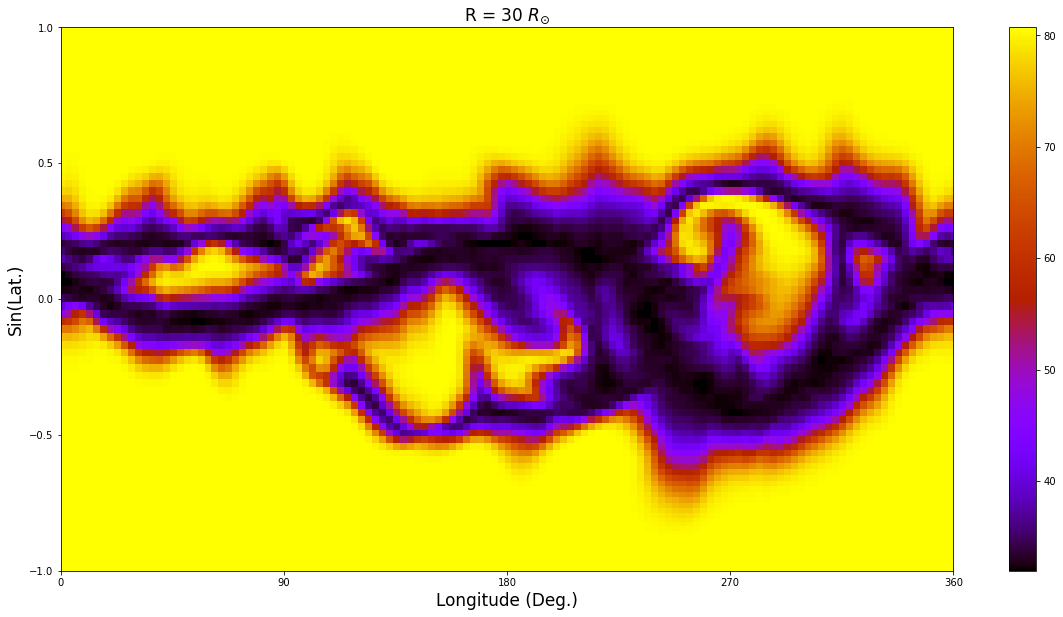

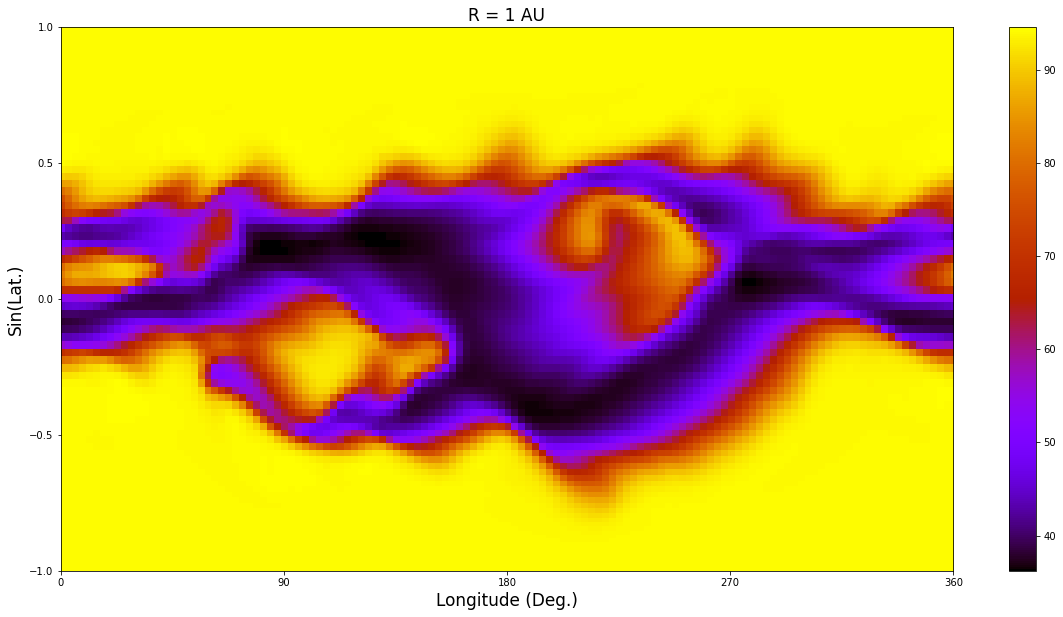

In [10]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p[0]], 0.5 * (p[1:] + p[:-1]), [p[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

fig, ax = plt.subplots()
ax.set_title("R = 30 $R_{\odot}$", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)

_ = im = ax.pcolorfast(ph*180/np.pi,th, v_initial.T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)


fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph*180/np.pi, th, v_final.T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

### After the unit adjutedments made above we get: 

- $v_{r}$ - solar radii/days.
- omega_rot = 1/days.
- phi - radians.
- r - solar radii.

$\Omega_{rot} = \frac{2\pi}{25.38} \frac{1}{days} = 0.24756 $

$ \frac{1}{\Omega_{rot}} = 4.03935$


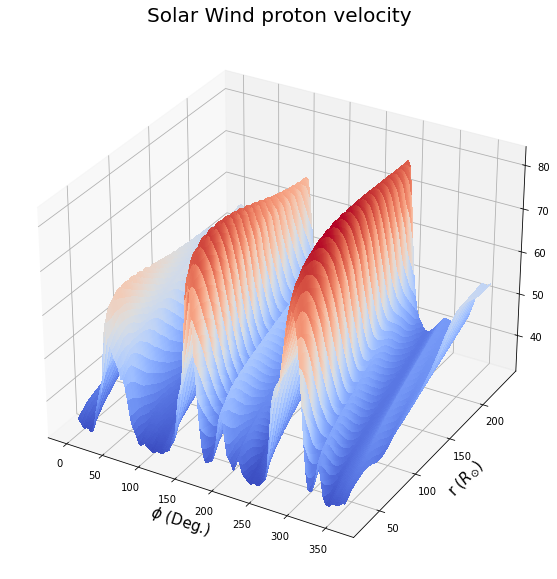

In [11]:
P, R = np.meshgrid(180*p/np.pi, r)
fig1 = figure(figsize=(10, 10))
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(P, R, slice_at_equator.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
_ = title('Solar Wind proton velocity', fontsize = 20)
_ = xlabel('$\phi$ (Deg.)', fontsize = 15)
_ = ylabel('r $(R_{\odot})$', fontsize = 15)

# Thermal Pressure dataset.

### The fluid momentum equation in corotating frame of reference

$$-\Omega_{rot} \frac{\partial v}{\partial \Phi} + (v \cdot \nabla)v = \frac{1}{\rho} \nabla P - \frac{G M_{s}}{r^2}e_{r}$$


By neglecting the gravity term, we get: 

$$-\Omega_{rot} \frac{\partial v}{\partial \Phi} + (v \cdot \nabla)v = \frac{1}{\rho} \nabla P$$

$$-\Omega_{rot} \frac{\partial v}{\partial \Phi} + v \frac{\partial v}{\partial r} = \frac{1}{\rho} \frac{ \partial P}{\partial r}$$

$$\frac{\partial v}{\partial \Phi} =\frac{1}{\Omega_{rot}}  v \frac{\partial v}{\partial r} - \frac{1}{\Omega_{rot}}\frac{1}{\rho} \frac{ \partial P}{\partial r}$$


units in MKS (for normalization): 

- $\Omega_{rot} - \frac{radians}{sec} - \frac{radians}{days}$


- $ v - \frac{km}{sec} - \frac{Solar Radii}{days}$

- $ \Phi - radians$

- $ r - km - Solar Radii$

- $ \rho (density) - \frac{kg}{m^3} - \frac{kg}{Solar Radii^3}$

- $ P (pressure) - 1 Pa - \frac{kg}{ms} - \frac{kg}{Solar Radii \cdot days}$

# Read in thermal pressure. 

![](figures/mas_conversion.png)

In [12]:
r_P, t_P, p_P, f_P = rdhdf_3d(os.path.join(data_dir,"p002.hdf"))
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p_P = np.append(p_P, 2*np.pi) 
# append the first slice p=0 to velocity matrix. 
f_P = np.append(f_P,[f_P[0,:, :]],axis=0)

In [13]:
# Velocity profile: PSI convertion units conversion from MAS to MKS. 
f_c = 3.875717* 1e-02 # in Pa
f_P = (f_c)*f_P

In [14]:
# mean + range
print("mean=", np.mean(f_P[:, :, -1]))
print("min=", np.min(f_P[:, :, -1]))
print("max=", np.max(f_P[:, :, -1]))

mean= 1.3457543e-11
min= 2.1092895e-12
max= 2.0201833e-10


In [15]:
print("Velocity matrix shape: ", np.shape(f_P))
print("Phi dim: ", np.shape(f_P)[0])
print("Theta dim: ", np.shape(f_P)[1])
print("Radial dim: ", np.shape(f_P)[2])
print("Velocity matrix dtype: ", f_P.dtype)

Velocity matrix shape:  (129, 111, 141)
Phi dim:  129
Theta dim:  111
Radial dim:  141
Velocity matrix dtype:  float32


In [16]:
# change scalers units: 
# Theta: from radians to degrees. colatitude. 
t_P[0] = 0
t_P[-1] = np.pi

In [17]:
t_plot_P = np.sin(np.pi/2 - t_P)

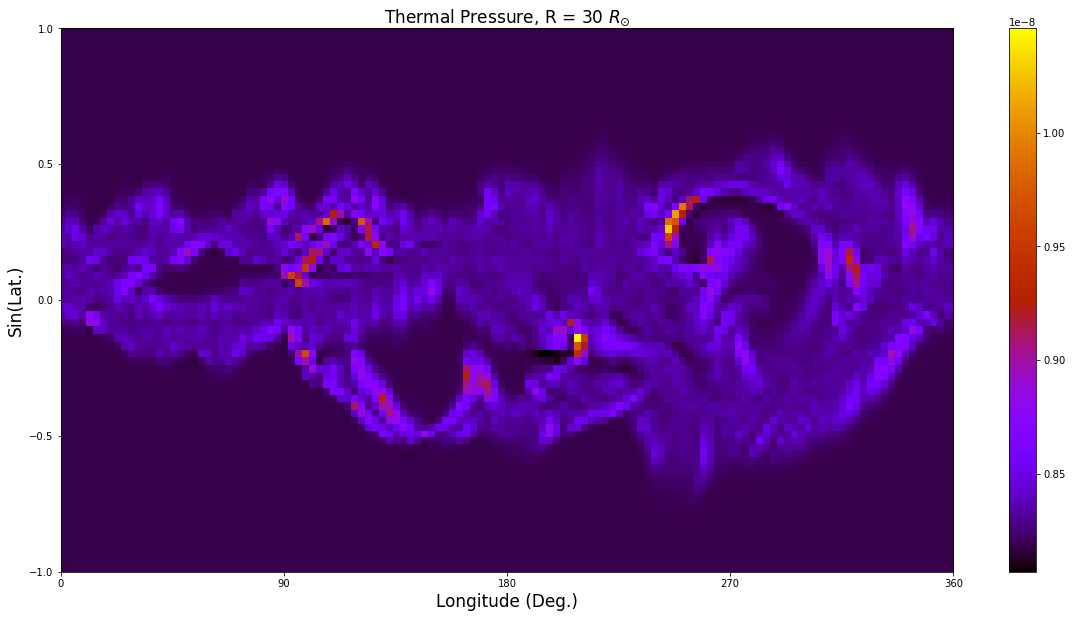

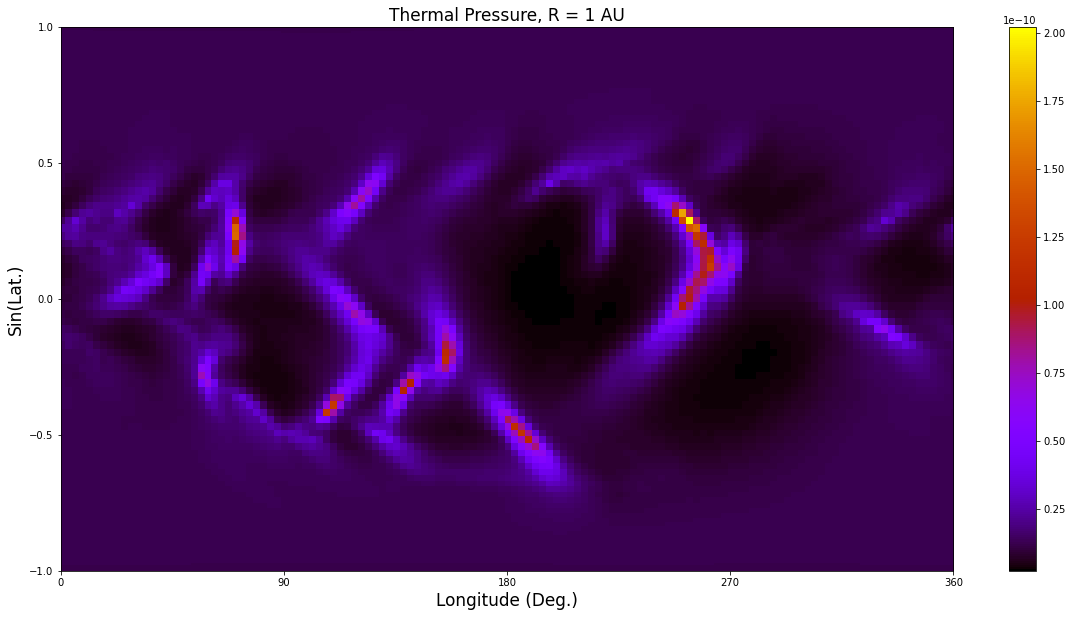

In [18]:
cmap = 'gnuplot'

ph_P = np.concatenate([[p_P[0]], 0.5 * (p_P[1:] + p_P[:-1]), [p_P[-1]]])
th_P = np.concatenate([[t_plot_P[0]], 0.5 * (t_plot_P[1:] + t_plot_P[:-1]), [t_plot_P[-1]]])

fig, ax = plt.subplots()
ax.set_title("Thermal Pressure, R = 30 $R_{\odot}$",  fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)

_ = im = ax.pcolorfast(ph_P*180/np.pi,th_P, f_P[:, :, 0].T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
ax.set_title("Thermal Pressure, R = 1 AU",  fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)

_ = im = ax.pcolorfast(ph_P*180/np.pi,th_P, f_P[:, :, -1].T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

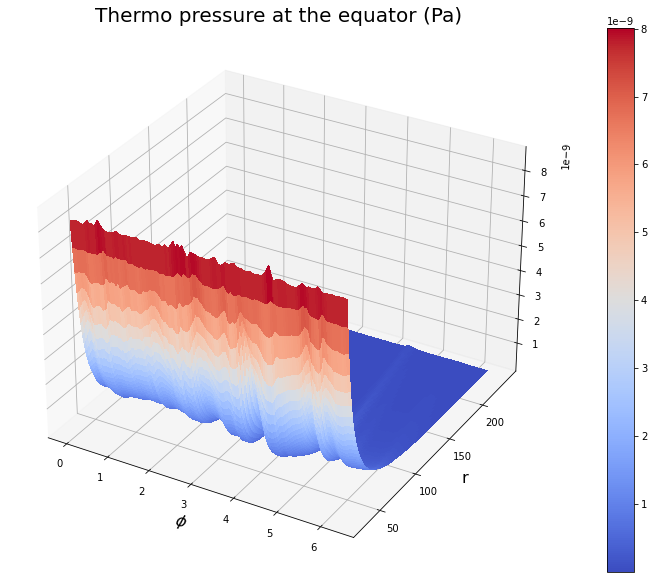

In [19]:
P, R = np.meshgrid(p_P, r_P)
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(P, R, f_P[:, 55, :].T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
_ = title('Thermo pressure at the equator (Pa)', fontsize = 20)
_ = xlabel('$\phi$', fontsize = 16)
_ = ylabel('r', fontsize = 16)
_ = fig1.colorbar(surf, ax=ax)

-0.7426619938441685

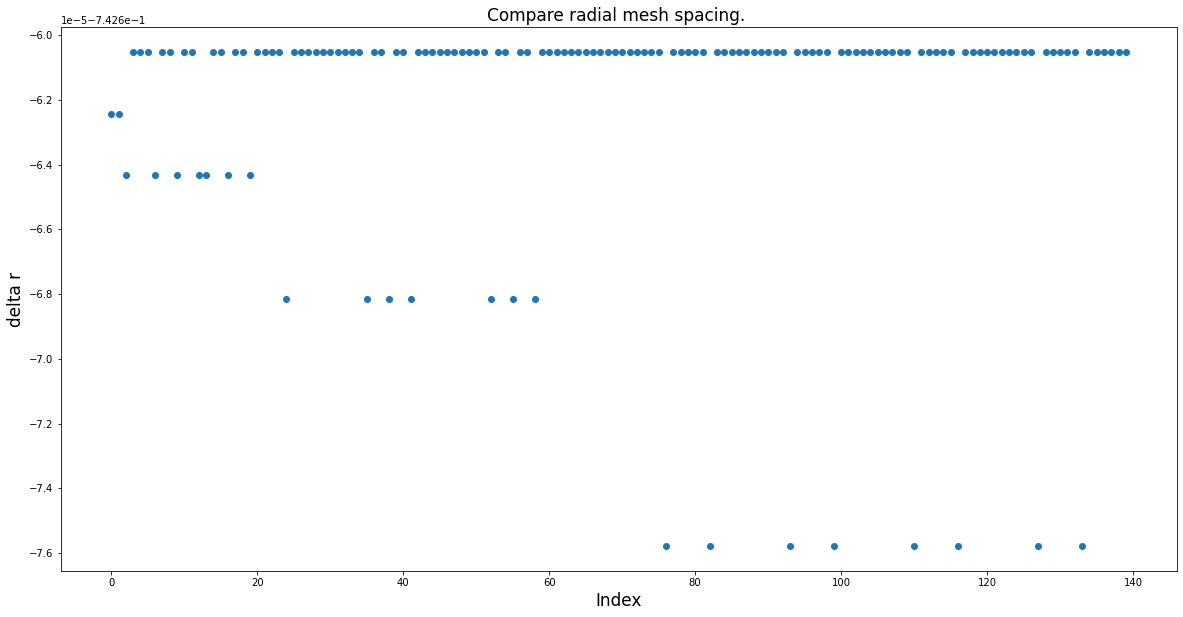

In [20]:
plt.scatter(np.arange(len(r)), r-r_P[1:])
plt.title("Compare radial mesh spacing. ", fontsize=17)
plt.xlabel("Index", fontsize=17)
plt.ylabel("delta r", fontsize=17)
np.mean(r-r_P[1:])

### There is a need to interpolate on the same mesh grid. Hence, I will move the thermal pressure results to match the velocity grid. 

In [21]:
# create a 3d mesh grid.
pp, tt, rr = numpy.meshgrid(p, t, r, indexing='ij')
coordinate_grid = numpy.array([pp.T, tt.T, rr.T]).T

print(r[-1])
print(r_P[-1])

236.4600067138672
237.20266723632812


In [22]:
# linear interpolation
interp_function = RegularGridInterpolator(points=(p_P, t_P,r_P), values=f_P, bounds_error=False, fill_value=None)

In [23]:
f_P_newgrid = interp_function(coordinate_grid)

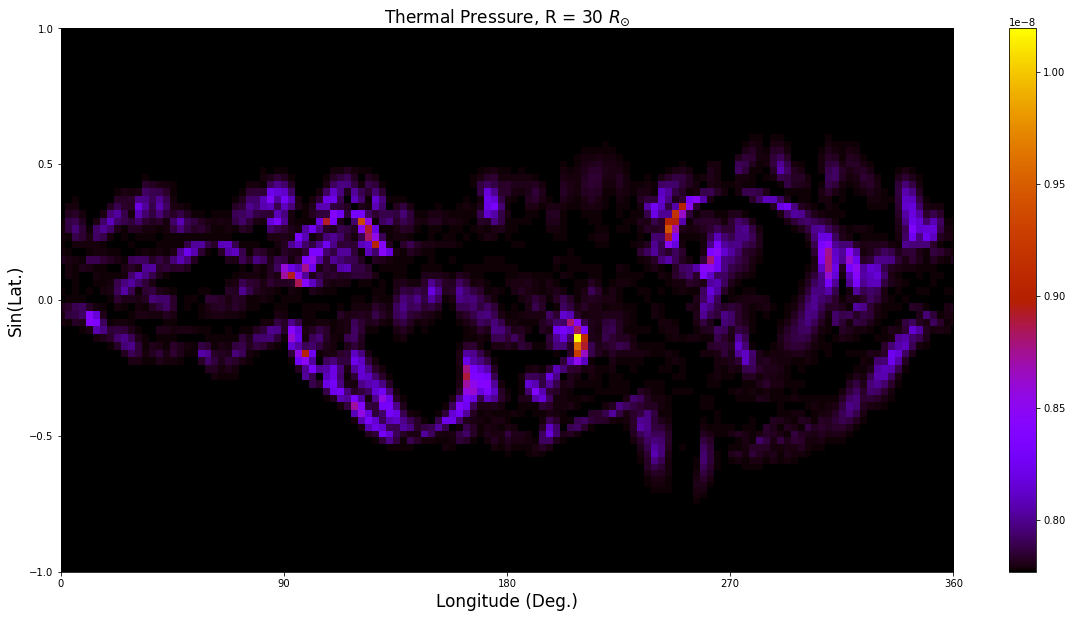

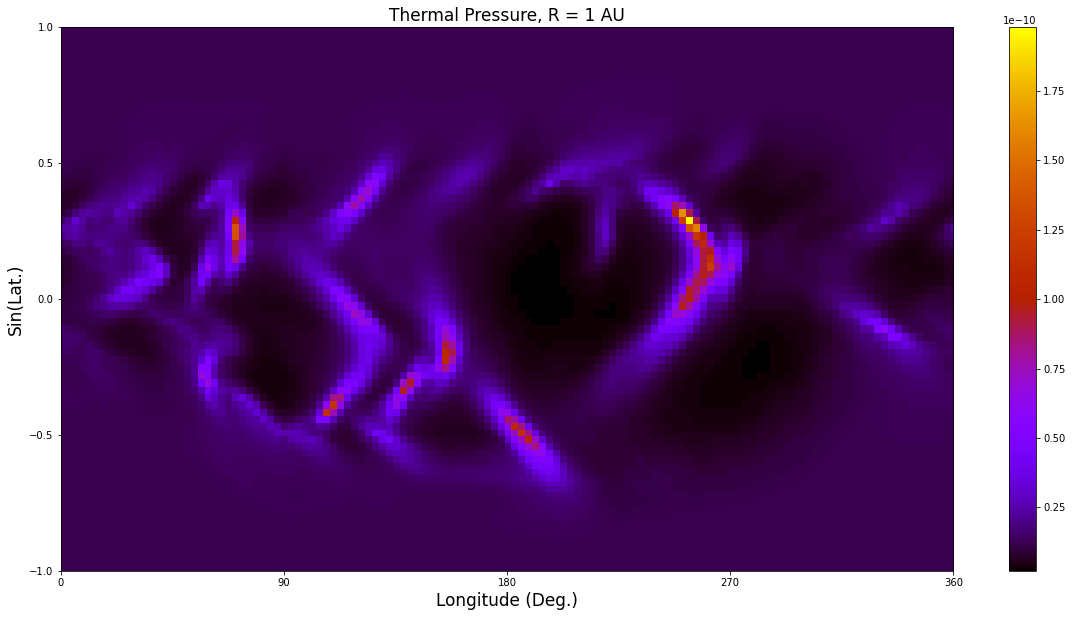

In [24]:
fig, ax = plt.subplots()
ax.set_title("Thermal Pressure, R = 30 $R_{\odot}$",  fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)

_ = im = ax.pcolorfast(ph_P*180/np.pi,th_P, f_P_newgrid[:, :, 0].T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
ax.set_title("Thermal Pressure, R = 1 AU",  fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)

_ = im = ax.pcolorfast(ph_P*180/np.pi,th_P, f_P_newgrid[:, :, -1].T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

# proton mass density dataset. 

In [25]:
r_d, t_d, p_d, f_d = rdhdf_3d(os.path.join(data_dir,"rho002.hdf"))
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p_d = np.append(p_d, 2*np.pi) 
# append the first slice p=0 to velocity matrix. 
f_d = np.append(f_d,[f_d[0,:, :]],axis=0)
# convert f_d to mks units
f_d = (1.6726*1e-13)*f_d
# change scalers units: 
# Theta: from radians to degrees. colatitude. 
t_d[0] = 0
t_d[-1] = np.pi

In [26]:
print("Velocity matrix shape: ", np.shape(f_d))
print("Phi dim: ", np.shape(f_d)[0])
print("Theta dim: ", np.shape(f_d)[1])
print("Radial dim: ", np.shape(f_d)[2])
print("Velocity matrix dtype: ", f_d.dtype)

Velocity matrix shape:  (129, 111, 141)
Phi dim:  129
Theta dim:  111
Radial dim:  141
Velocity matrix dtype:  float32


In [27]:
t_plot_d = np.sin(np.pi/2 - t_d)

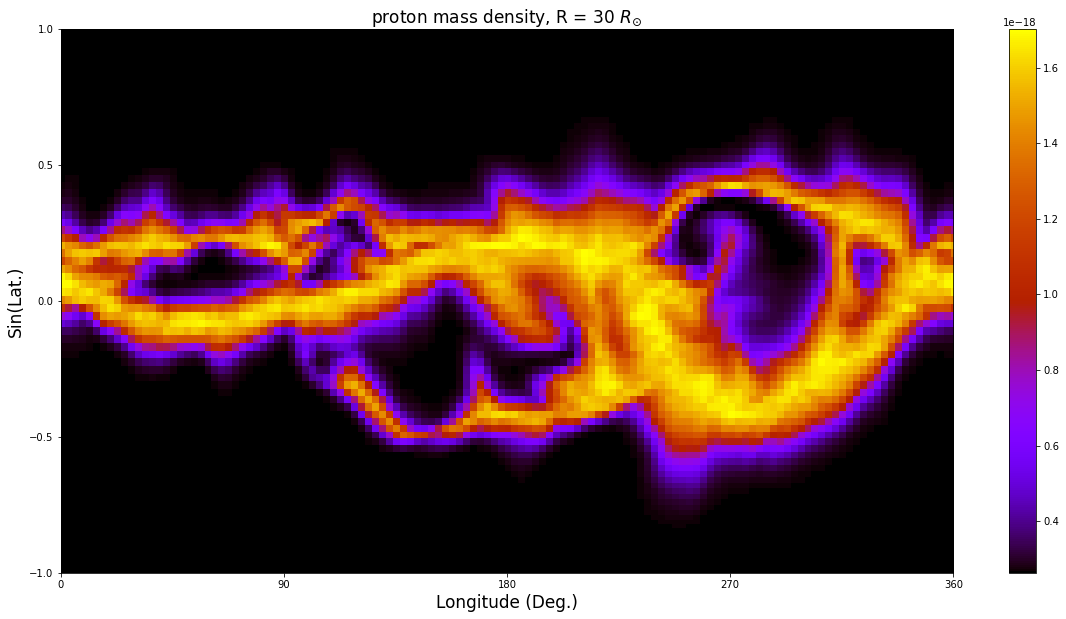

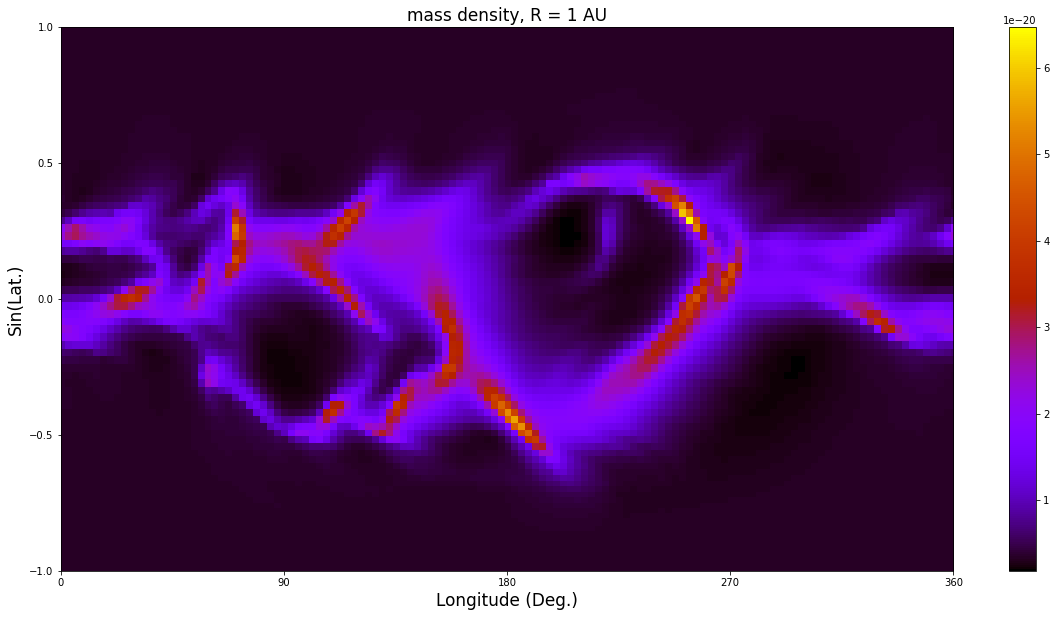

In [28]:
cmap = 'gnuplot'

ph_d = np.concatenate([[p_d[0]], 0.5 * (p_d[1:] + p_d[:-1]), [p_d[-1]]])
th_d = np.concatenate([[t_plot_d[0]], 0.5 * (t_plot_d[1:] + t_plot_d[:-1]), [t_plot_d[-1]]])

fig, ax = plt.subplots()
ax.set_title("proton mass density, R = 30 $R_{\odot}$", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)

_ = im = ax.pcolorfast(ph_d*180/np.pi,th_d, f_d[:, :, 0].T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)


fig, ax = plt.subplots()
ax.set_title("mass density, R = 1 AU", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)

_ = im = ax.pcolorfast(ph_d*180/np.pi,th_d, f_d[:, :, -1].T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

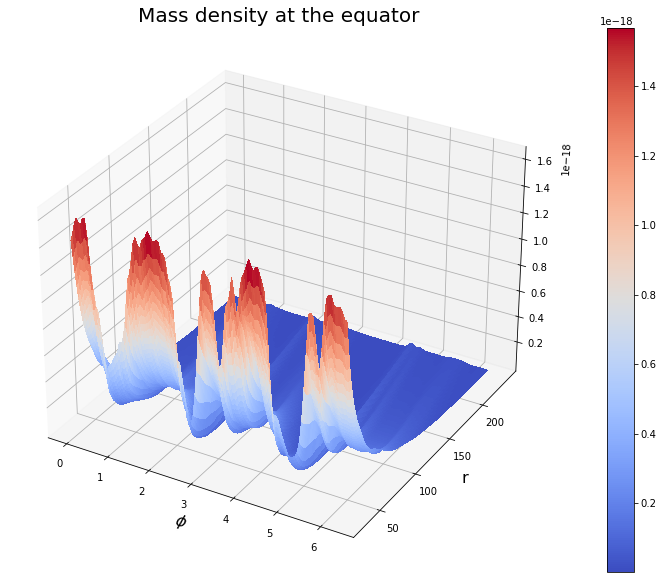

In [29]:
P, R = np.meshgrid(p_d, r_d)
fig1 = figure()
ax = fig1.gca(projection='3d')
slice_at_equator_d = f_d[:, 55, :]
surf = ax.plot_surface(P, R, slice_at_equator_d.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
_ = title('Mass density at the equator', fontsize = 20)
_ = xlabel('$\phi$', fontsize = 16)
_ = ylabel('r', fontsize = 16)
_ = fig1.colorbar(surf, ax=ax)

0.7426617894853864

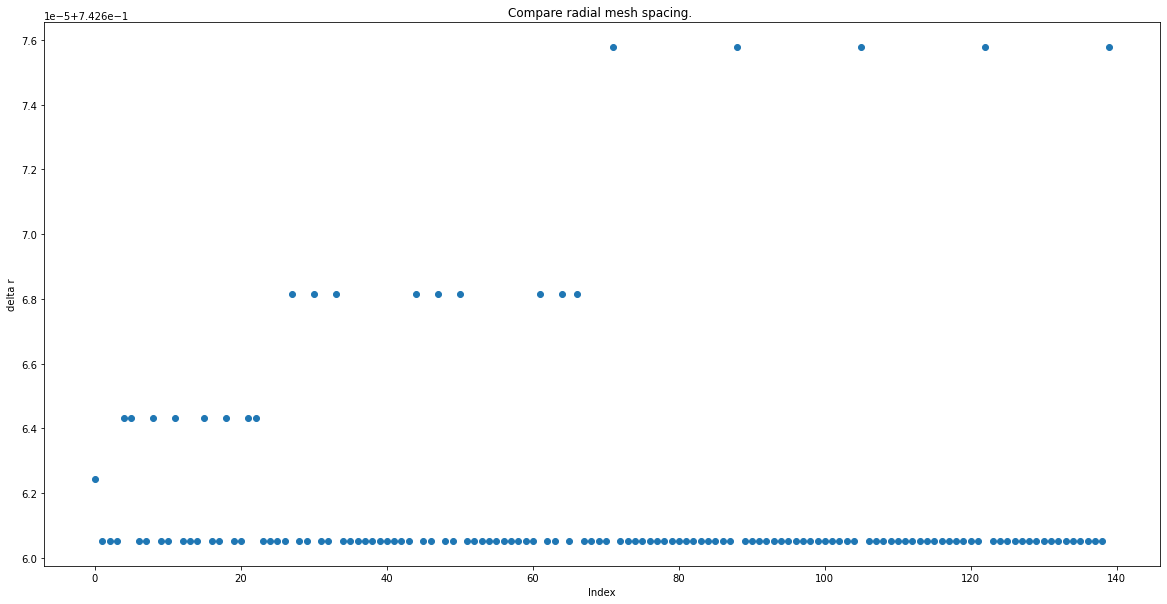

In [30]:
plt.scatter(np.arange(len(r)), r-r_d[:-1])
plt.title("Compare radial mesh spacing. ")
plt.xlabel("Index")
plt.ylabel("delta r")
np.mean(r-r_d[:-1])

### There is a need to interpolate on the same mesh grid. Hence, I will move the thermal pressure results to match the velocity grid. 

In [31]:
# create a 3d mesh grid.
pp, tt, rr = numpy.meshgrid(p, t, r, indexing='ij')
coordinate_grid = numpy.array([pp.T, tt.T, rr.T]).T

print(r[-1])
print(r_d[-1])

236.4600067138672
237.20266723632812


In [32]:
# linear interpolation
interp_function = RegularGridInterpolator(points=(p_d, t_d,r_d), values=f_d, bounds_error=False, fill_value=None)

In [33]:
f_d_newgrid = interp_function(coordinate_grid)

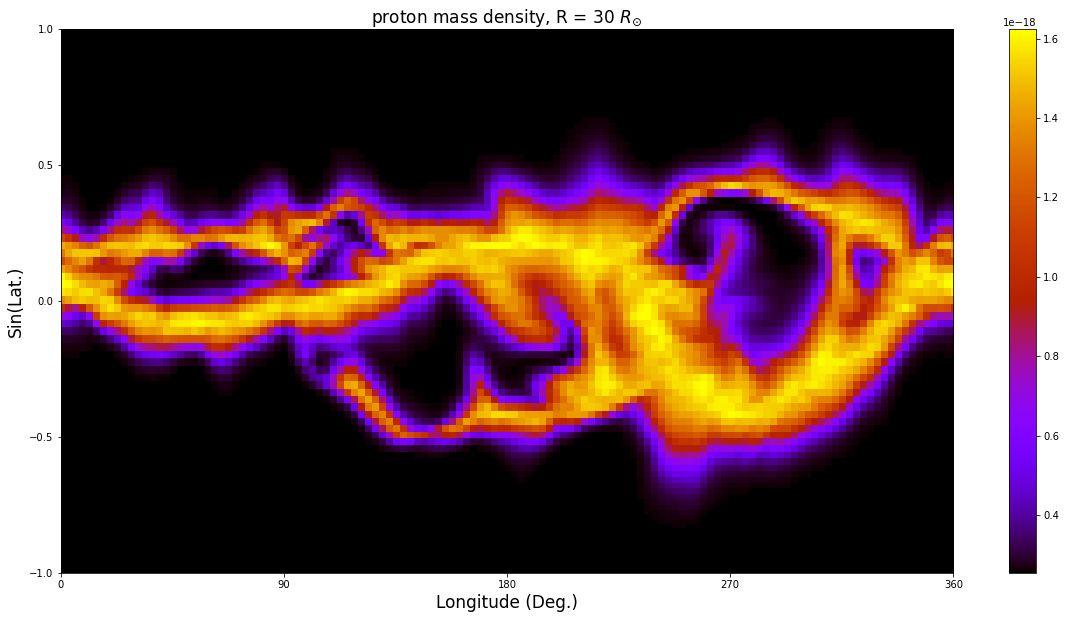

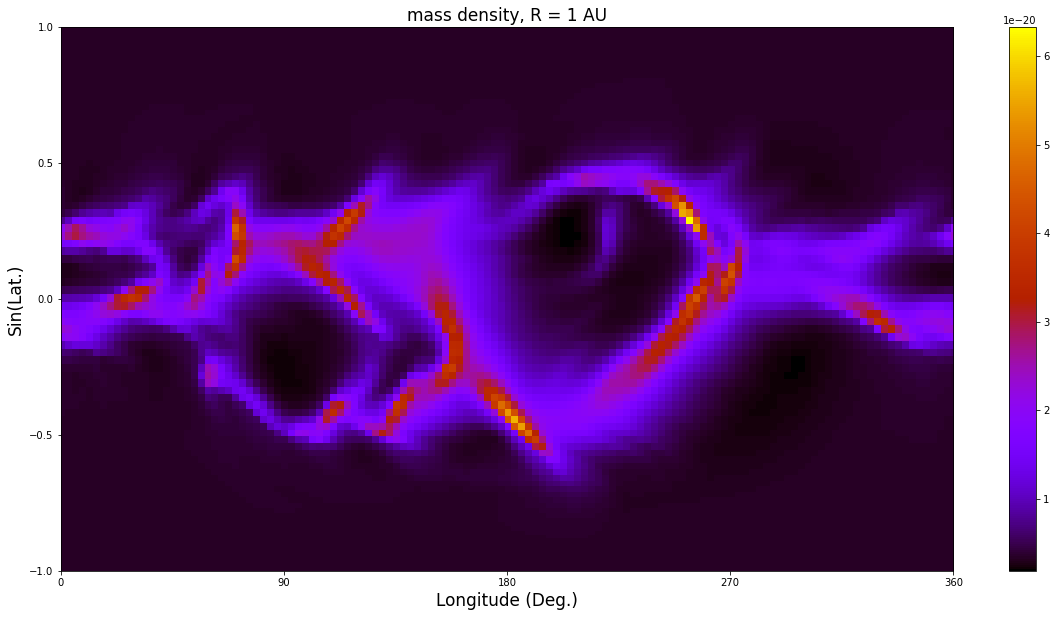

In [34]:
fig, ax = plt.subplots()
ax.set_title("proton mass density, R = 30 $R_{\odot}$", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)

_ = im = ax.pcolorfast(ph_d*180/np.pi,th_d, f_d_newgrid[:, :, 0].T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)


fig, ax = plt.subplots()
ax.set_title("mass density, R = 1 AU", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)

_ = im = ax.pcolorfast(ph_d*180/np.pi,th_d, f_d_newgrid[:, :, -1].T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

# Compute $\nabla P$/p term

In [35]:
dr = r[1:] - r[:-1]
dp = p[1:] - p[:-1]

In [36]:
dr_avg = np.mean(dr)

In [37]:
# convert units to  kg/(RS day^2)
pressure_at_equator = f_P_newgrid[:, 55, :]*(86400**2)*(695700*1000)

In [38]:
# convert units to  kg/(RS^3)
density_at_equator = f_d_newgrid[:, 55, :]*((695700*1000)**3)

In [39]:
extra_element = np.divide(np.gradient(pressure_at_equator, dr_avg ,axis=1), density_at_equator)

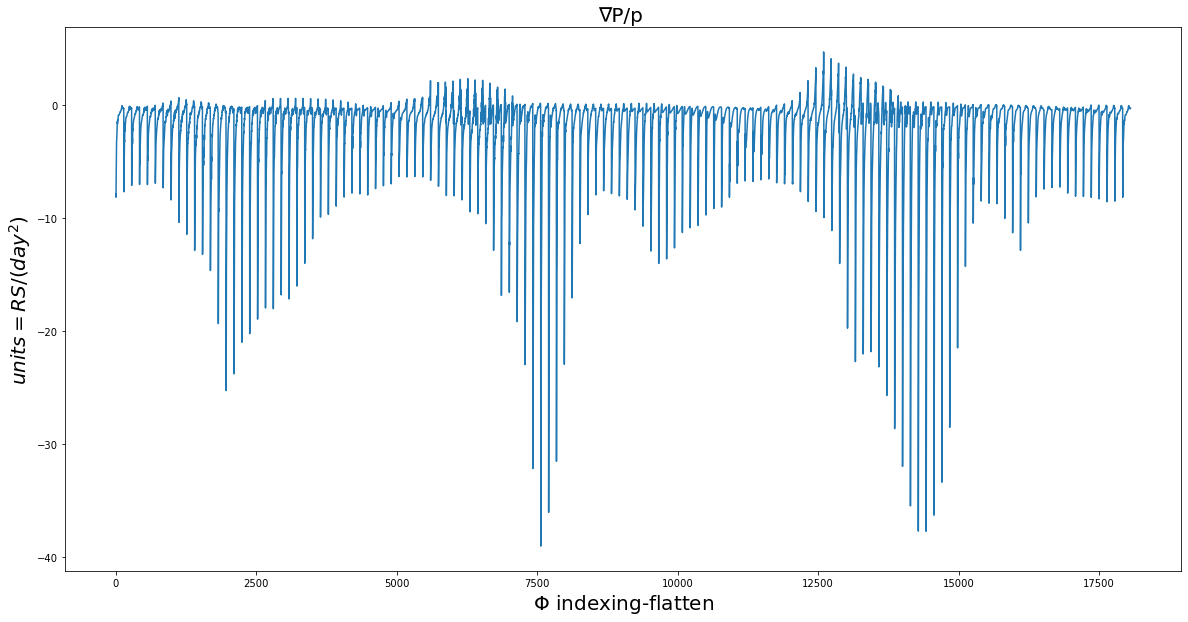

In [40]:
_ = plt.plot(extra_element.flatten())
_ = plt.title("∇P/p ", fontsize=20)
_ = plt.xlabel("$\Phi$ indexing-flatten", fontsize=20)
_ = plt.ylabel("$units= RS/(day^2)$", fontsize=20)

# Step 2: Construct $\Theta (U)$ and compute partials. 


$$
\frac{\partial v_{r}}{\partial \phi} =\Theta(\frac{\partial v_{r}}{\partial r}, v_{r}\frac{\partial v_{r}}{\partial r}, \frac{\partial^2 v_{r}}{\partial r^2}, v_{r}^2\frac{\partial^2 v_{r}}{\partial r^2}, v_{r}^3, \frac{\partial^2 v_{r}}{\partial \phi^2} , \frac{1}{\rho} \nabla P, ...)\xi 
$$
    

In [41]:
dr_avg = np.mean(dr)
dp_avg = np.mean(dp)

print("Average dr", dr_avg)
print("Average dp", dp_avg)

Average dr 1.485323789308397
Average dp 0.04908738521234052


In [42]:
slice_at_equator.shape

(129, 140)

In [43]:
up = np.gradient(slice_at_equator, dp_avg, axis=0)
ux = np.gradient(slice_at_equator, dr_avg, axis=1)

In [44]:
# build theta. 
# second partial with respect to phi. 
upp = np.gradient(up, dr_avg, axis=0)
# second partial with respect to r. 
uxx = np.gradient(ux, dr_avg, axis=1)
# vr. 
u = slice_at_equator
# sine of u 
sine = np.sin(u)
# cos of vr
cos = np.cos(u)
# vr*dv/dr
uux = np.zeros((u.shape[0], u.shape[1]))
# v^2*dv/dr
u2ux = np.zeros((u.shape[0], u.shape[1]))
# v* dv/dp
uup = np.zeros((u.shape[0], u.shape[1]))
# 1/vr^2
u2 = np.zeros((u.shape[0], u.shape[1]))
# vr * d2v/dr2
uuxx = np.zeros((u.shape[0], u.shape[1]))
# vr^2 * d2v/dr2
u2uxx = np.zeros((u.shape[0], u.shape[1]))

for ii in range(u.shape[0]):
    for jj in range(u.shape[1]):
        uux[ii, jj] = u[ii, jj] * ux[ii, jj]
        u2[ii, jj] = u[ii, jj]**2
        uup[ii, jj] = u[ii, jj]* up[ii, jj]
        uuxx[ii, jj] = u[ii, jj] * uxx[ii, jj]
        u2uxx[ii, jj] = u2[ii, jj] * uxx[ii, jj]
        u2ux[ii, jj] =  u2[ii, jj] * ux[ii, jj]

In [45]:
lhs = up.flatten() # partial with respect to phi. 
rhs = np.zeros((len(lhs), 13)) # up to order 2, 9 elements. 
# Meaning: u_x, uu_x, u^2u_x, u_xx, uu_xx, u^2u_xx, u^2, u
rhs[:, 0] = ux.flatten()
rhs[:, 1] = uux.flatten()
rhs[:, 2] = u2ux.flatten()
rhs[:, 3] = uxx.flatten()
rhs[:, 4] = uuxx.flatten()
rhs[:, 5] = u2uxx.flatten()
rhs[:, 6] = u2.flatten()
rhs[:, 7] = u.flatten()
rhs[:, 8] = uup.flatten()
rhs[:, 9] = upp.flatten()
rhs[:, 10] = sine.flatten()
rhs[:, 11] = cos.flatten()
rhs[:, 12] = extra_element.flatten()

In [46]:
# check the condition number of the matrix above. 
format(np.linalg.cond(rhs), ".3E")

'4.010E+06'

## Since the condition number of the matrix above is very high (1e+6) then we need to find the correlation between the different elements. 

In [47]:
labels= [r"$\dfrac{\partial v_{r}}{\partial r}$", 
                    r"$v_{r}\dfrac{\partial v_{r}}{\partial r}$", 
                    r"$v_{r}^{2}\dfrac{\partial v_{r}}{\partial r}$", 
                    r"$\dfrac{\partial^2v_{r}}{\partial r^2}$", 
                    r"$v_{r} \dfrac{\partial^2 v_{r}}{\partial r^2}$",
                    r"$v_{r}^2 \dfrac{\partial^2 v_{r}}{\partial r^2}$",
                    r"$v_{r}^2 $",
                    r"$v_{r} $",
                    r"$v_{r} \dfrac{\partial v_{r}}{\partial \phi} $",
                    r"$\dfrac{\partial^2 v_{r}}{\partial \phi^2}$",
                    r"$\sin(v_{r})$",
                    r"$\cos(v_{r})$",
                    r"$\frac{1}{\rho} \nabla P$"
                   ]

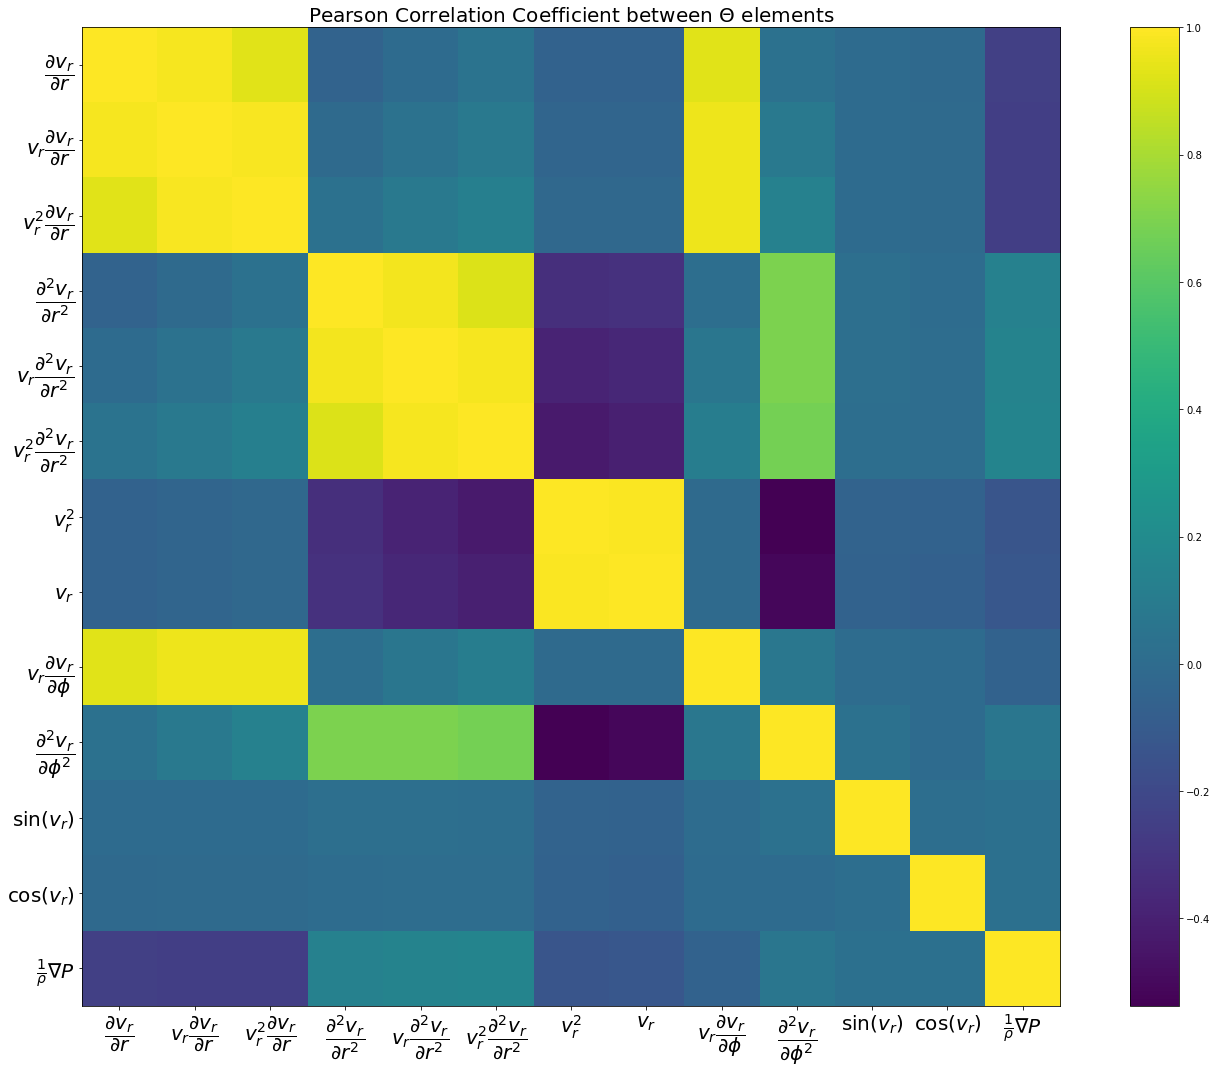

In [48]:
num_elements = 13

fig, ax = plt.subplots(figsize=(25, 18))
corr_mat = np.zeros((num_elements, num_elements))

for jj in range(num_elements):
    for ii in range(num_elements):
        corr_mat[ii, jj] = stats.pearsonr(rhs[:, jj], rhs[:, ii])[0]
        
im = ax.imshow(corr_mat)
ax.set_xticks(np.arange(num_elements))
ax.set_yticks(np.arange(num_elements))
ax.set_xticklabels(labels, fontsize=20)
ax.set_yticklabels(labels, fontsize=20)
ax.set_title("Pearson Correlation Coefficient between $\Theta$ elements", fontsize=20)
plt.savefig("figures/PCCThetaMat.png",transparent=False)
_ = fig.colorbar(im)

### Figure explained:
From the figure above we can identify the elements that have high correlation which will increase the condition number of our matrix $\Theta$. High condition number will increase the diffuculty of solving the linear system using sparse regression. 

highly correlated:

[$\dfrac{\partial v_{r}}{\partial r}$, $v_{r}\dfrac{\partial v_{r}}{\partial r}$, $v_{r}^{2}\dfrac{\partial v_{r}}{\partial r}$, $v_{r} \dfrac{\partial v_{r}}{\partial \phi}$]

[$\dfrac{\partial^2v_{r}}{\partial r^2}$, $v_{r} \dfrac{\partial^2 v_{r}}{\partial r^2}$, $v_{r}^2 \dfrac{\partial^2 v_{r}}{\partial r^2}$]

[$v_{r}^2$, $v_{r}$]

In [49]:
rhs = np.zeros((len(lhs), 8)) # up to order 2, 6 elements.
# Meaning: uu_x, u_xx, u, upp, nabla P
rhs[:, 0] = uux.flatten()
rhs[:, 1] = uxx.flatten()
rhs[:, 2] = u.flatten()
rhs[:, 3] = upp.flatten()
rhs[:, 4] = sine.flatten()
rhs[:, 5] = cos.flatten()
rhs[:, 6] = extra_element.flatten()
rhs[:, 7] = np.ones(np.shape(uux.flatten()))

In [50]:
labels2 = [r"$v_{r}\dfrac{\partial v_{r}}{\partial r}$", 
           r"$\dfrac{\partial^2v_{r}}{\partial r^2}$", 
           r"$v_{r} $",
           r"$\dfrac{\partial^2 v_{r}}{\partial \phi^2}$",
           r"$\sin(v_{r})$",
           r"$\cos(v_{r})$",
           r"$\frac{1}{\rho} \nabla P$",
           r"$1$"
           ]

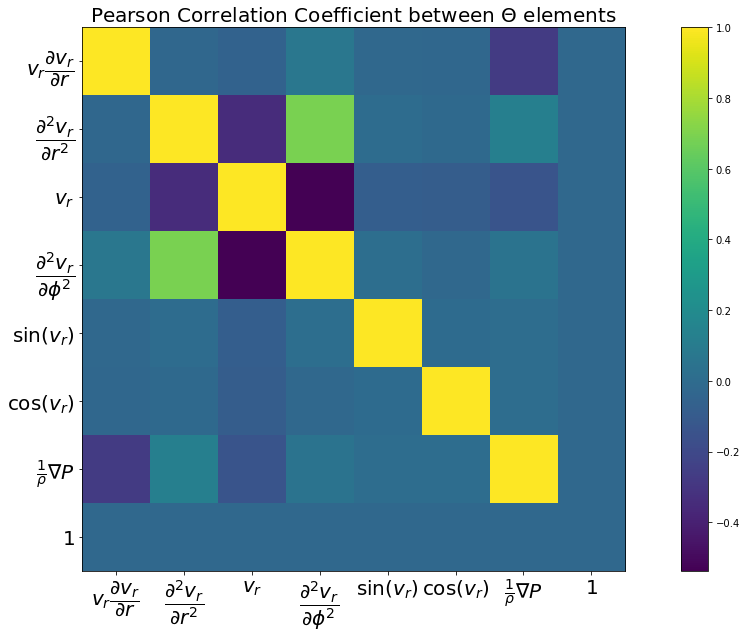

In [51]:
num_elements = np.shape(rhs)[-1]

fig, ax = plt.subplots()
corr_mat = np.zeros((num_elements, num_elements))

for jj in range(num_elements-1):
    for ii in range(num_elements-1):
        corr_mat[ii, jj] = stats.pearsonr(rhs[:, jj], rhs[:, ii])[0]
        
ax.imshow(corr_mat)    
ax.set_xticks(np.arange(num_elements))
ax.set_yticks(np.arange(num_elements))
ax.set_xticklabels(labels2, fontsize=20)
ax.set_yticklabels(labels2, fontsize=20)
ax.set_title("Pearson Correlation Coefficient between $\Theta$ elements", fontsize=20)
_ = fig.colorbar(im)

In [52]:
format(np.linalg.cond(rhs), ".3E")

'3.705E+03'

# Step 3: find the optimal combination using ridge sparse regression. 

$$\xi^{*} = argmin_\xi || \frac{\partial v_{r}}{\partial \phi} - \Theta\xi ||_{2}^2 + \lambda ||\xi||_{2}^2$$


$$
\frac{\partial v_{r}}{\partial \phi} = \Theta\xi 
$$


$$\Theta = \begin{bmatrix}
    \vert & \vert & \vert & \vert & \vert & \vert & \vert & \vert \\
                v_{r}\frac{\partial v_{r}}{\partial r}  & \frac{\partial^2 v_{r}}{\partial r^2} & v_{r} & \frac{\partial^2 v_{r}}{\partial \phi^2} & \sin(v_{r}) &  \cos(v_{r}) &  \frac{1}{\rho} \nabla P & 1\\
    \vert & \vert & \vert & \vert & \vert & \vert & \vert & \vert
\end{bmatrix}
$$

In [53]:
sol = scipy.sparse.linalg.lsqr(A=rhs, b=lhs, damp=1e2, atol=1e-16, btol=1e-12, conlim=1e6, iter_lim=None, show=True, calc_var=False, x0=None)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 18060 rows and 8 columns
damp = 1.00000000000000e+02   calc_var =        0
atol = 1.00e-16                 conlim = 1.00e+06
btol = 1.00e-12               iter_lim =       16
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.366e+03  7.366e+03    1.0e+00  2.7e-01
     1  3.37481e+00   2.258e+03  2.281e+03    3.1e-01  9.3e-01   2.1e+03  1.0e+00
     2  3.41105e+00   2.139e+03  2.166e+03    2.9e-01  1.1e-01   6.5e+03  3.3e+00
     3  3.45102e+00   2.004e+03  2.034e+03    2.8e-01  4.8e-02   7.2e+03  5.2e+00
     4  3.62527e+00   1.365e+03  1.451e+03    2.0e-01  1.8e-04   7.3e+03  1.7e+01
     5  3.62526e+00   1.364e+03  1.450e+03    2.0e-01  2.4e-05   7.3e+03  5.6e+01
     6  3.62526e+00   1.364e+03  1.450e+03    2.0e-01  7.4e-06   7.3e+03  9.0e+01
     7  3.62526e+00   1.364e+03  1.450e+03    2.0e-01  6.3e-07   9.8e+03  1.2e+02
     8  3.62526e+00   1.364e+03  1.4

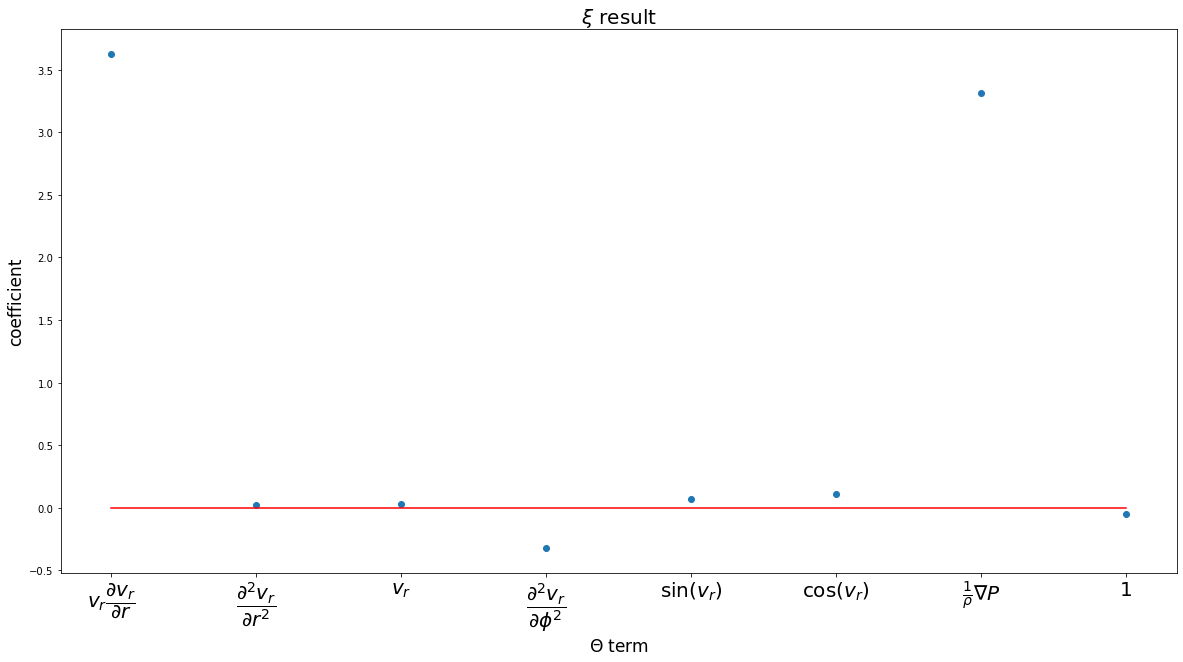

In [54]:
fig, ax = plt.subplots()

_ = ax.scatter(np.arange(len(sol[0])), sol[0])
_ = ax.plot(np.arange(len(sol[0])), np.zeros(len(sol[0])), "r")
_ = ax.set_ylabel("coefficient", fontsize=17)
_ = ax.set_xlabel("$\Theta$ term", fontsize=17)
_ = ax.set_xticks(np.arange(len(sol[0])))
_ = ax.set_xticklabels(labels2, fontsize=20)
_ = ax.set_title("$\\xi$ result", fontsize=20)

In [55]:
sol[0]

array([ 3.62526194,  0.02229901,  0.03121686, -0.32248376,  0.07037728,
        0.1063808 ,  3.31006758, -0.05244188])

## Notice that the most dominant terms are $v_{r}\dfrac{\partial v_{r}}{\partial r}$, $\dfrac{\nabla P}{p}$,$\dfrac{\partial^2 v_{r}}{\partial \phi^2}$.

In [56]:
# Compute the exact coefficients. 
thresh = 0.2
rhs2 = np.copy(rhs)
for ii in range(len(sol[0])):
    if np.abs(sol[0][ii]) < thresh:
        rhs2[:, ii] = np.zeros(rhs[:, 0].shape)

In [57]:
sol2 = scipy.sparse.linalg.lsqr(A=rhs2, b=lhs, damp=1, atol=1e-14, btol=1e-08, conlim=1e5, iter_lim=None, show=True, calc_var=False, x0=None)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 18060 rows and 8 columns
damp = 1.00000000000000e+00   calc_var =        0
atol = 1.00e-14                 conlim = 1.00e+05
btol = 1.00e-08               iter_lim =       16
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.366e+03  7.366e+03    1.0e+00  2.7e-01
     1  3.39469e+00   2.217e+03  2.217e+03    3.0e-01  3.4e-01   2.1e+03  1.0e+00
     2  3.44178e+00   2.065e+03  2.065e+03    2.8e-01  1.5e-01   2.8e+03  2.0e+00
     3  3.63914e+00   1.378e+03  1.378e+03    1.9e-01  4.3e-15   3.1e+03  6.6e+00
 
LSQR finished
The least-squares solution is good enough, given atol     
 
istop =       2   r1norm = 1.4e+03   anorm = 3.1e+03   arnorm = 1.8e-08
itn   =       3   r2norm = 1.4e+03   acond = 6.6e+00   xnorm  = 4.9e+00
 


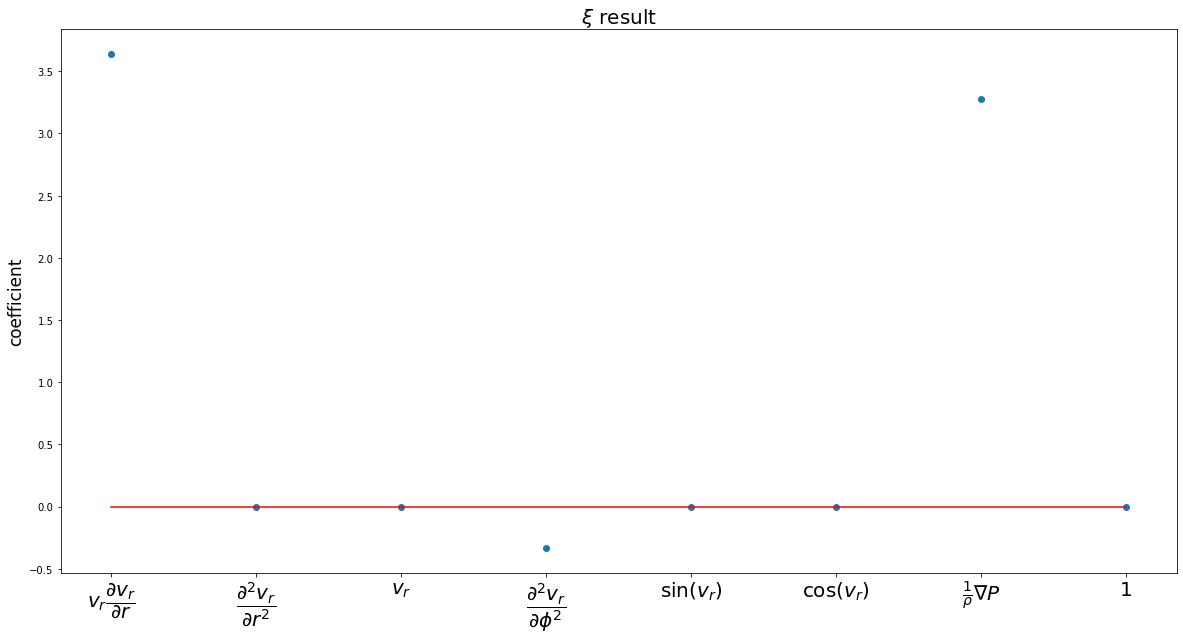

In [58]:
fig, ax = plt.subplots()

_ = ax.scatter(np.arange(len(sol2[0])), sol2[0])
_ = ax.plot(np.arange(len(sol2[0])), np.zeros(len(sol2[0])), "r")
_ = ax.set_ylabel("coefficient", fontsize=17)
#_ = ax.set_xlabel("term index", fontsize=17)
_ = ax.set_xticks(np.arange(len(sol[0])))
_ = ax.set_xticklabels(labels2, fontsize=20)
_ = ax.set_title("$\\xi$ result", fontsize=20)

In [59]:
sol2[0]

array([ 3.6391375 ,  0.        ,  0.        , -0.33471046,  0.        ,
        0.        ,  3.27480596,  0.        ])

In [60]:
rhs_res_1 = 0 
for ii in range(len(sol[0])):
    rhs_res_1 += sol2[0][ii] * rhs2[:, ii] 

In [61]:
mse_res1 = (np.square(lhs - rhs_res_1)).mean()

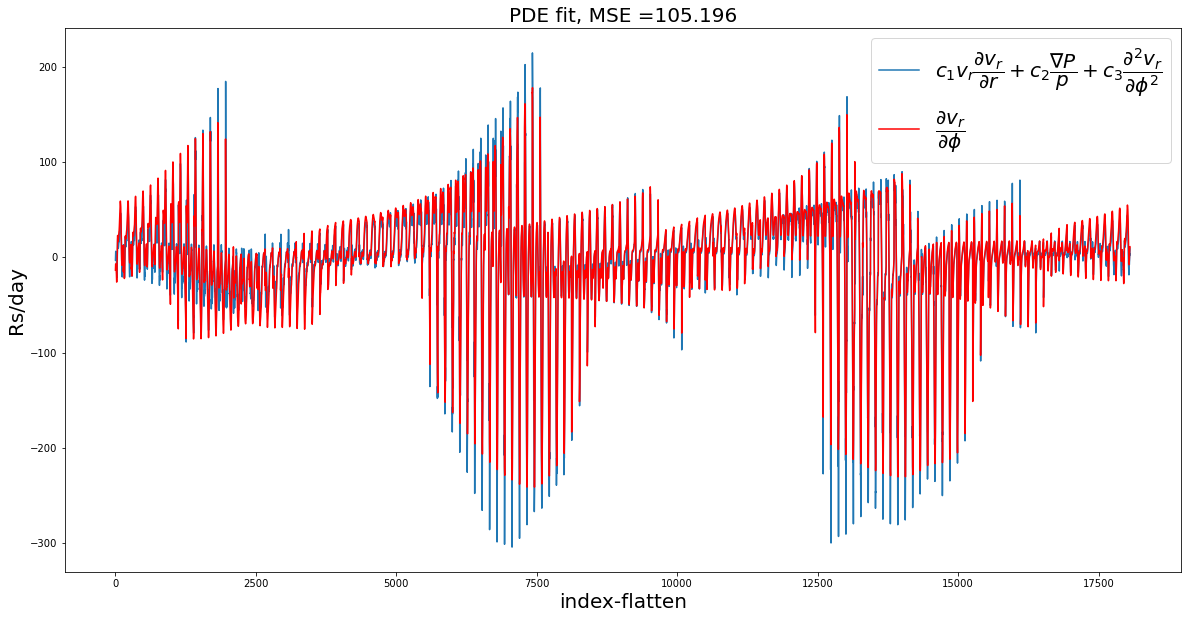

In [62]:
# plot the solution and observe if the rhs equals the lhs.
_ = plt.plot(rhs_res_1, label="$c_{1}v_{r}\dfrac{\partial v_{r}}{\partial r} + c_{2} \dfrac{∇P}{p}+ c_{3} \dfrac{\partial^2 v_{r}}{\partial \phi^2}$")
_ = plt.plot(lhs, label="$\dfrac{\partial v_{r}}{\partial \phi}$", color='r')
_ = plt.legend(fontsize=20)
_ = plt.ylabel("Rs/day", fontsize=20)
_ = plt.xlabel("index-flatten", fontsize=20)
_ = plt.title("PDE fit, MSE =" + str(round(mse_res1, 3)), fontsize=20)

# Compute the fit of $\dfrac{\partial v_{r}}{\partial \phi}= c_{1}v_{r}\dfrac{\partial v_{r}}{\partial r} + c_{2} \dfrac{\nabla P}{\rho}$

In [63]:
rhs2 = np.zeros(rhs.shape)
rhs2[:, 0] = uux.flatten()
rhs2[:, 6] = extra_element.flatten()

In [64]:
sol3 = scipy.sparse.linalg.lsqr(A=rhs2, b=lhs, damp=1, atol=1e-14, btol=1e-08, conlim=1e5, iter_lim=None, show=True, calc_var=False, x0=None)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 18060 rows and 8 columns
damp = 1.00000000000000e+00   calc_var =        0
atol = 1.00e-14                 conlim = 1.00e+05
btol = 1.00e-08               iter_lim =       16
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.366e+03  7.366e+03    1.0e+00  2.7e-01
     1  3.39458e+00   2.218e+03  2.218e+03    3.0e-01  1.7e-01   2.1e+03  1.0e+00
     2  3.59947e+00   1.567e+03  1.567e+03    2.1e-01  3.1e-15   2.1e+03  4.5e+00
 
LSQR finished
The least-squares solution is good enough, given atol     
 
istop =       2   r1norm = 1.6e+03   anorm = 2.1e+03   arnorm = 1.0e-08
itn   =       2   r2norm = 1.6e+03   acond = 4.5e+00   xnorm  = 4.8e+00
 


In [65]:
print(sol3[0])

[3.59946794 0.         0.         0.         0.         0.
 3.1466512  0.        ]


In [66]:
rhs_res_2 = 0 
for ii in range(len(sol[0])):
    rhs_res_2 += sol3[0][ii] * rhs[:, ii] 
    
mse_res2 = (np.square(lhs - rhs_res_2)).mean()

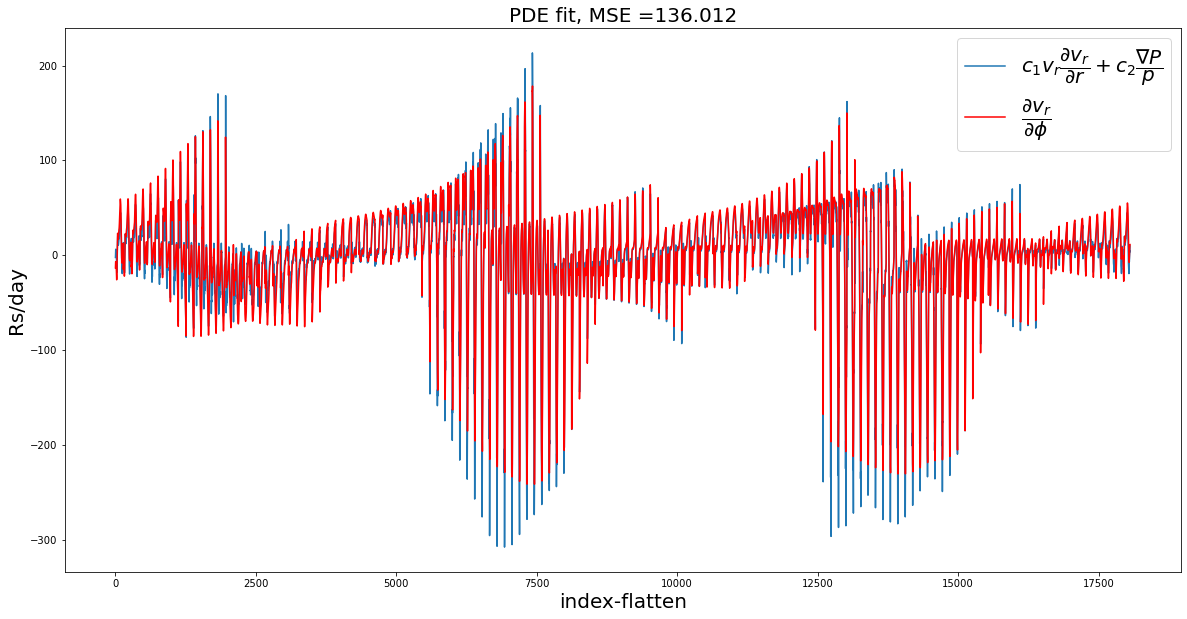

In [67]:
# plot the solution and observe if the rhs equals the lhs.
_ = plt.plot(rhs_res_2, label="$c_{1}v_{r}\dfrac{\partial v_{r}}{\partial r} + c_{2} \dfrac{∇P}{p}$")
_ = plt.plot(lhs, label="$\dfrac{\partial v_{r}}{\partial \phi}$", color='r')
_ = plt.legend(fontsize=20)
_ = plt.ylabel("Rs/day", fontsize=20)
_ = plt.xlabel("index-flatten", fontsize=20)
_ = plt.title("PDE fit, MSE =" + str(round(mse_res2, 3)), fontsize=20)

# Compute the MSE of inviscid burgers' equation with added diffusion element (THUX).   $\dfrac{\partial v_{r}}{\partial \phi}= c_{1}v_{r}\dfrac{\partial v_{r}}{\partial r} + c_{2} \dfrac{\partial^2 v_{r}}{\partial \phi^2}$

In [68]:
rhs2 = np.zeros(rhs.shape)
rhs2[:, 0] = uux.flatten()
rhs2[:, 3] = upp.flatten()

In [69]:
sol4 = scipy.sparse.linalg.lsqr(A=rhs2, b=lhs, damp=0, atol=1e-08, btol=1e-08, conlim=100000000.0, iter_lim=None, show=True, calc_var=False, x0=None)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 18060 rows and 8 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       16
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.366e+03  7.366e+03    1.0e+00  2.7e-01
     1  3.39911e+00   2.204e+03  2.204e+03    3.0e-01  3.0e-01   2.1e+03  1.0e+00
     2  3.42478e+00   2.118e+03  2.118e+03    2.9e-01  1.7e-16   3.1e+03  2.0e+00
 
LSQR finished
The least-squares solution is good enough, given atol     
 
istop =       2   r1norm = 2.1e+03   anorm = 3.1e+03   arnorm = 1.1e-09
itn   =       2   r2norm = 2.1e+03   acond = 2.0e+00   xnorm  = 3.4e+00
 


In [70]:
print(sol4[0])

[ 3.42477752  0.          0.         -0.27385473  0.          0.
  0.          0.        ]


In [71]:
rhs_res_3 = 0 
for ii in range(len(sol[0])):
    rhs_res_3 += sol4[0][ii] * rhs[:, ii] 

In [72]:
mse_res3 = (np.square(lhs - rhs_res_3)).mean() 

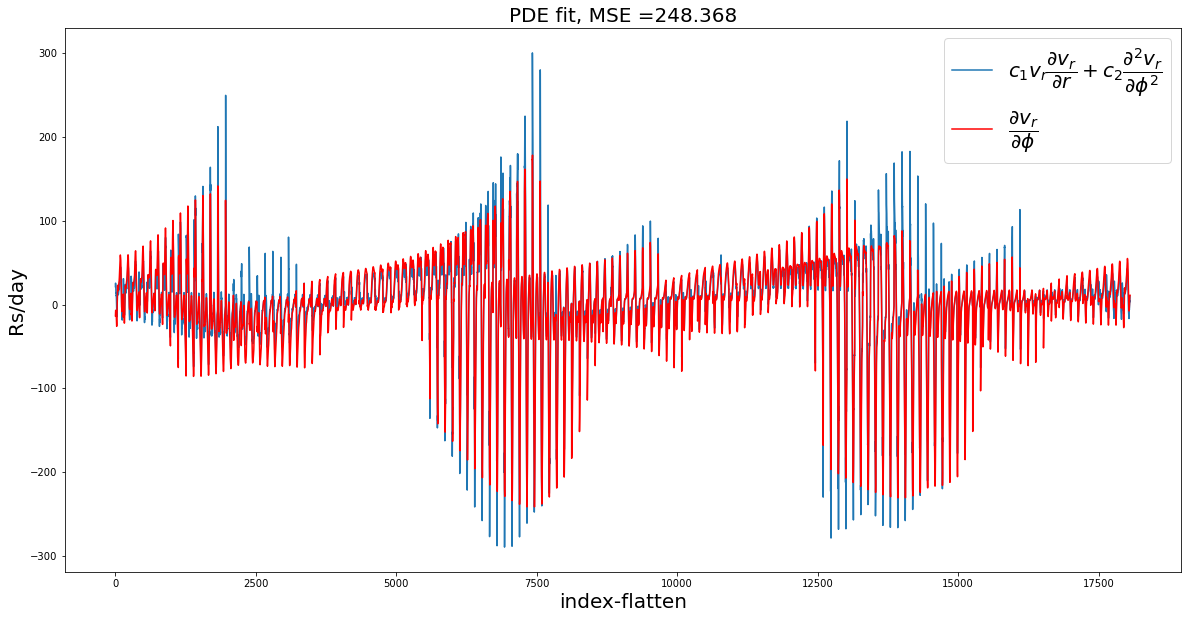

In [73]:
# plot the solution and observe if the rhs equals the lhs.
_ = plt.plot(rhs_res_3, label="$c_{1}v_{r}\dfrac{\partial v_{r}}{\partial r} + c_{2} \dfrac{\partial^2 v_{r}}{\partial \phi^2}$")
_ = plt.plot(lhs, label="$\dfrac{\partial v_{r}}{\partial \phi}$", color='r')
_ = plt.legend(fontsize=20)
_ = plt.ylabel("Rs/day", fontsize=20)
_ = plt.xlabel("index-flatten", fontsize=20)
_ = plt.title("PDE fit, MSE =" + str(round(mse_res3, 3)), fontsize=20)

# Compute the MSE of invisicid burger's equation fit $\dfrac{\partial v_{r}}{\partial \phi}= c_{1}v_{r}\dfrac{\partial v_{r}}{\partial r}$

In [74]:
rhs2[:, 3] =  np.zeros(len(lhs))
sol5 = scipy.sparse.linalg.lsqr(A=rhs2, b=lhs, damp=0, atol=1e-08, btol=1e-08, conlim=100000000.0, iter_lim=None, show=True, calc_var=False, x0=None)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 18060 rows and 8 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       16
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.366e+03  7.366e+03    1.0e+00  2.7e-01
     1  3.39900e+00   2.205e+03  2.205e+03    3.0e-01  4.7e-16   2.1e+03  1.0e+00
 
LSQR finished
The least-squares solution is good enough, given atol     
 
istop =       2   r1norm = 2.2e+03   anorm = 2.1e+03   arnorm = 2.2e-09
itn   =       1   r2norm = 2.2e+03   acond = 1.0e+00   xnorm  = 3.4e+00
 


In [75]:
print(sol5[0])

[3.39900061 0.         0.         0.         0.         0.
 0.         0.        ]


In [76]:
rhs_res_4 = sol5[0][0]*uux.flatten() 
mse_res_4 = (np.square(lhs - rhs_res_4)).mean() 

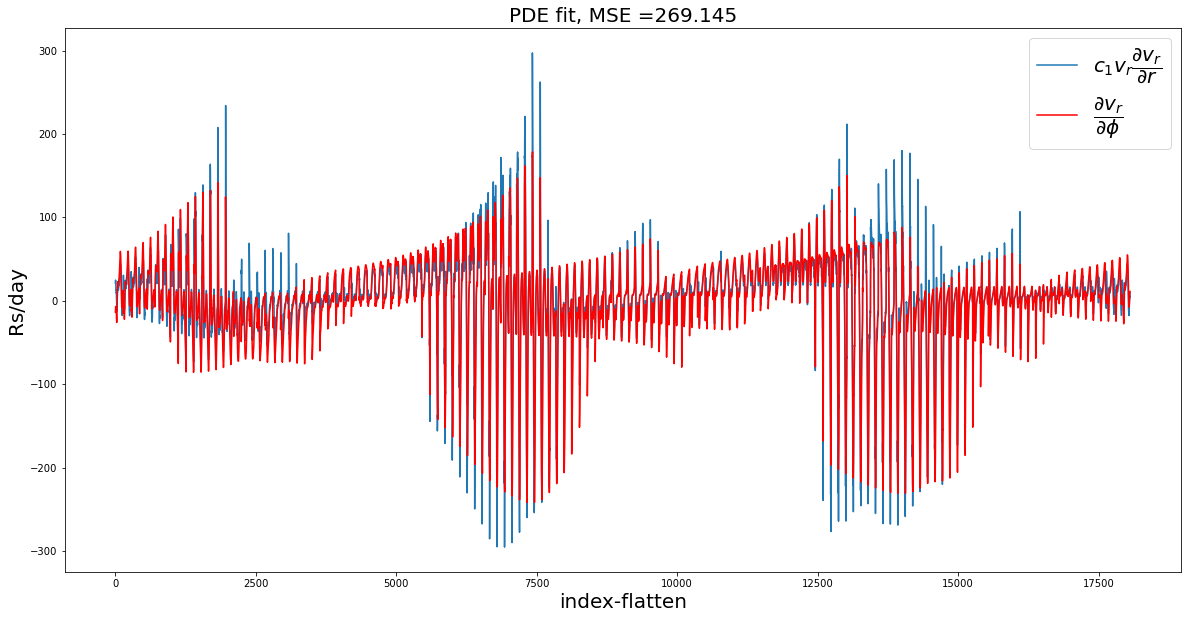

In [77]:
# plot the solution and observe if the rhs equals the lhs.
_ = plt.plot(rhs_res_4, label="$c_{1}v_{r} \dfrac{\partial v_{r}}{\partial r}$")
_ = plt.plot(lhs, label="$\dfrac{\partial v_{r}}{\partial \phi}$", color='r')
_ = plt.legend(fontsize=20)
_ = plt.ylabel("Rs/day", fontsize=20)
_ = plt.xlabel("index-flatten", fontsize=20)
_ = plt.title("PDE fit, MSE =" + str(round(mse_res_4, 3)), fontsize=20)

# Relative error


In [78]:
error1 = np.linalg.norm(rhs_res_1 - lhs)/np.linalg.norm(lhs)
error2 = np.linalg.norm(rhs_res_2 - lhs)/np.linalg.norm(lhs)
error3 = np.linalg.norm(rhs_res_3 - lhs)/np.linalg.norm(lhs)
error4 = np.linalg.norm(rhs_res_4 - lhs)/np.linalg.norm(lhs)

In [79]:
print("The relative error PDE-FIT with pressure and density term and diffusion term = ", error1)

The relative error PDE-FIT with pressure and density term and diffusion term =  0.18713350549703753


In [80]:
print("The relative error PDE-FIT of invisicid burgers equation with extra pressure and density term = ", error2)

The relative error PDE-FIT of invisicid burgers equation with extra pressure and density term =  0.21278471651066147


In [81]:
print("The relative error PDE-FIT of invisicid burgers equation with additional diffusion term = ", error3)

The relative error PDE-FIT of invisicid burgers equation with additional diffusion term =  0.28754138484251807


In [82]:
print("The relative error PDE-FIT of invisicid burgers equation = ", error4)

The relative error PDE-FIT of invisicid burgers equation =  0.2993266830750295


In [83]:
print("Adding the extra terms will reduce the relative error by " +  str(100*(error4-error1)) + str("%."))

Adding the extra terms will reduce the relative error by 11.2193177577992%.


In [84]:
print("Adding the gradient pressure over density term will reduce the relative error by " +  str(100*(error4-error2)) + str("%."))

Adding the gradient pressure over density term will reduce the relative error by 8.654196656436804%.


In [85]:
print("Adding the diffusion term will reduce the relative error by " +  str(100*(error4-error3)) + str("%."))

Adding the diffusion term will reduce the relative error by 1.1785298232511454%.


# Pearson correlation coefficient

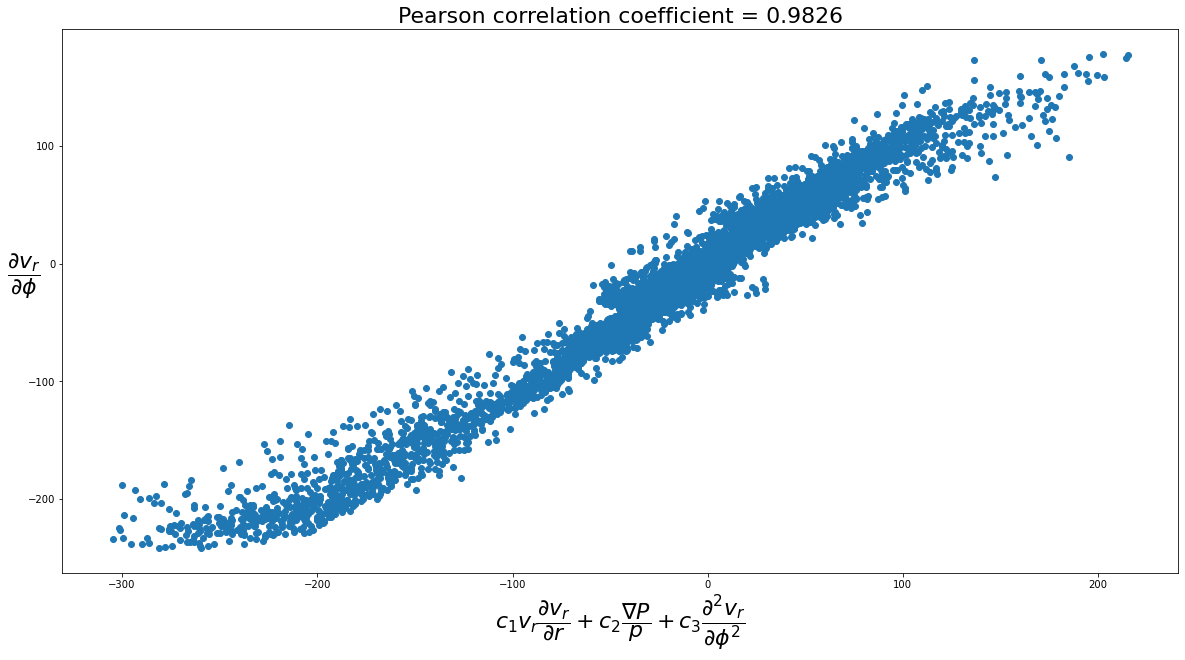

In [86]:
fig, ax = plt.subplots()
_ = ax.scatter(rhs_res_1, lhs)
_ = ax.set_xlabel("$c_{1}v_{r}\dfrac{\partial v_{r}}{\partial r} + c_{2} \dfrac{∇P}{p}+ c_{3} \dfrac{\partial^2 v_{r}}{\partial \phi^2}$", fontsize=22)
_ = ax.set_ylabel("$\dfrac{\partial v_{r}}{\partial \phi}$", fontsize=22, rotation=0)
_ = ax.set_title("Pearson correlation coefficient = " + str(round(stats.pearsonr(rhs_res_1, lhs)[0], 4)), fontsize=22)

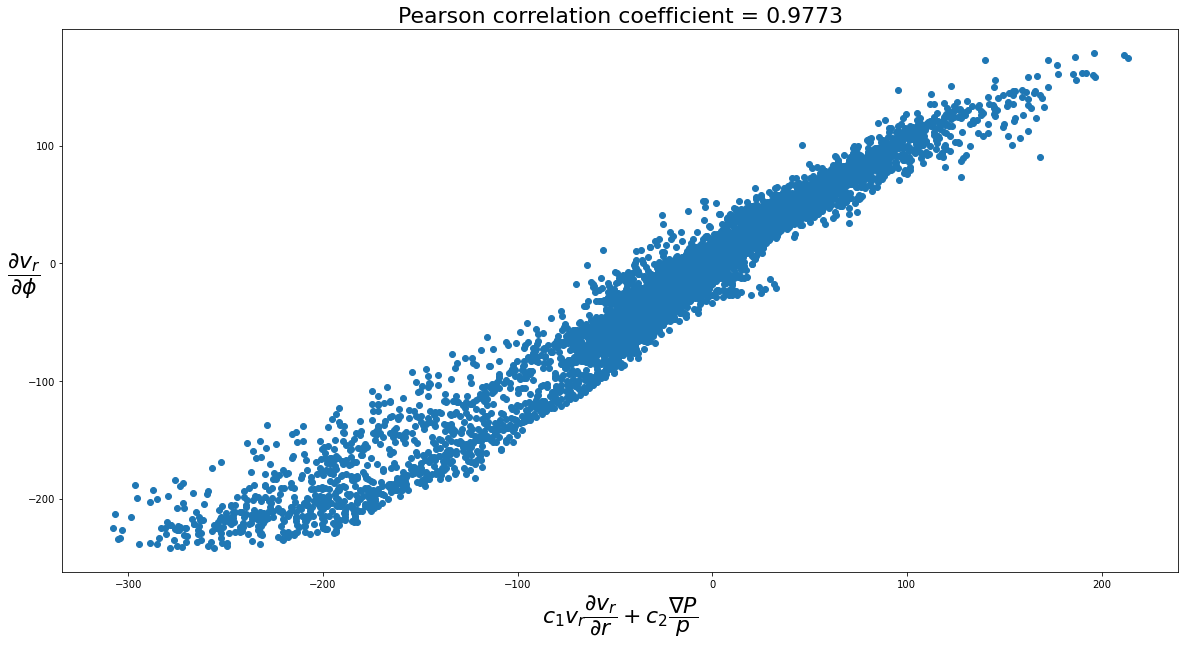

In [87]:
fig, ax = plt.subplots()
_ = ax.scatter(rhs_res_2, lhs)
_ = ax.set_xlabel("$c_{1}v_{r}\dfrac{\partial v_{r}}{\partial r} + c_{2} \dfrac{∇P}{p}$", fontsize=22)
_ = ax.set_ylabel("$\dfrac{\partial v_{r}}{\partial \phi}$", fontsize=22, rotation=0)
_ = ax.set_title("Pearson correlation coefficient = " + str(round(stats.pearsonr(rhs_res_2, lhs)[0], 4)), fontsize=22)

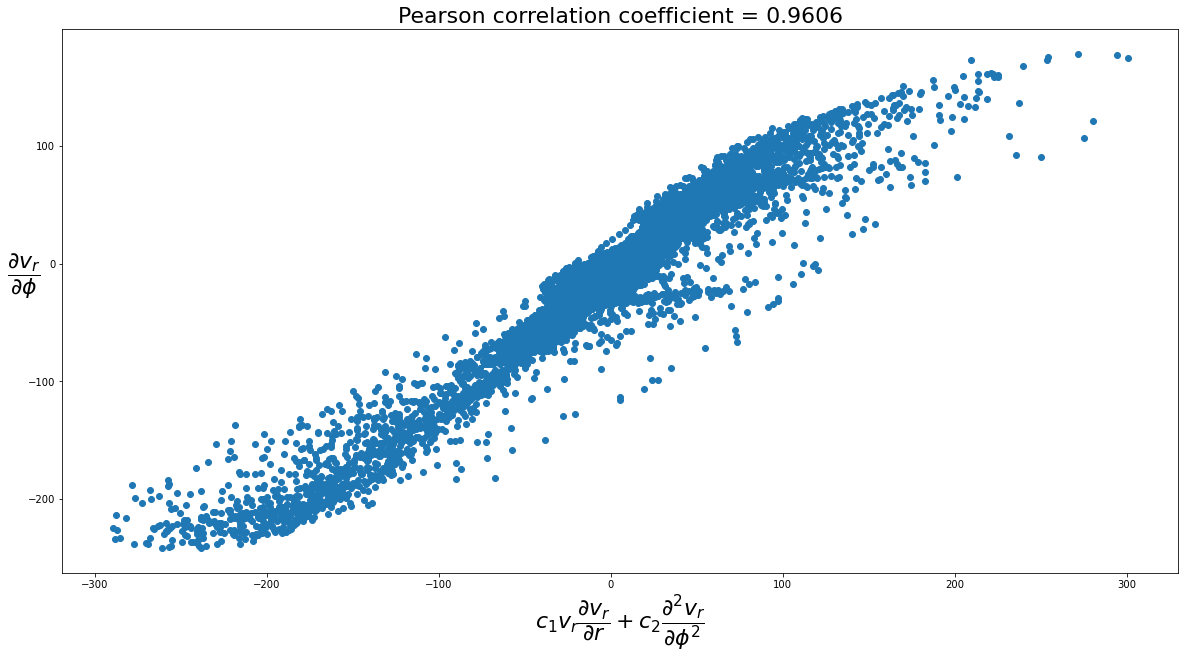

In [88]:
fig, ax = plt.subplots()
_ = ax.scatter(rhs_res_3, lhs)
_ = ax.set_xlabel("$c_{1}v_{r}\dfrac{\partial v_{r}}{\partial r} + c_{2} \dfrac{\partial^2 v_{r}}{\partial \phi^2}$", fontsize=22)
_ = ax.set_ylabel("$\dfrac{\partial v_{r}}{\partial \phi}$", fontsize=22, rotation=0)
_ = ax.set_title("Pearson correlation coefficient = " + str(round(stats.pearsonr(rhs_res_3, lhs)[0], 4)), fontsize=22)

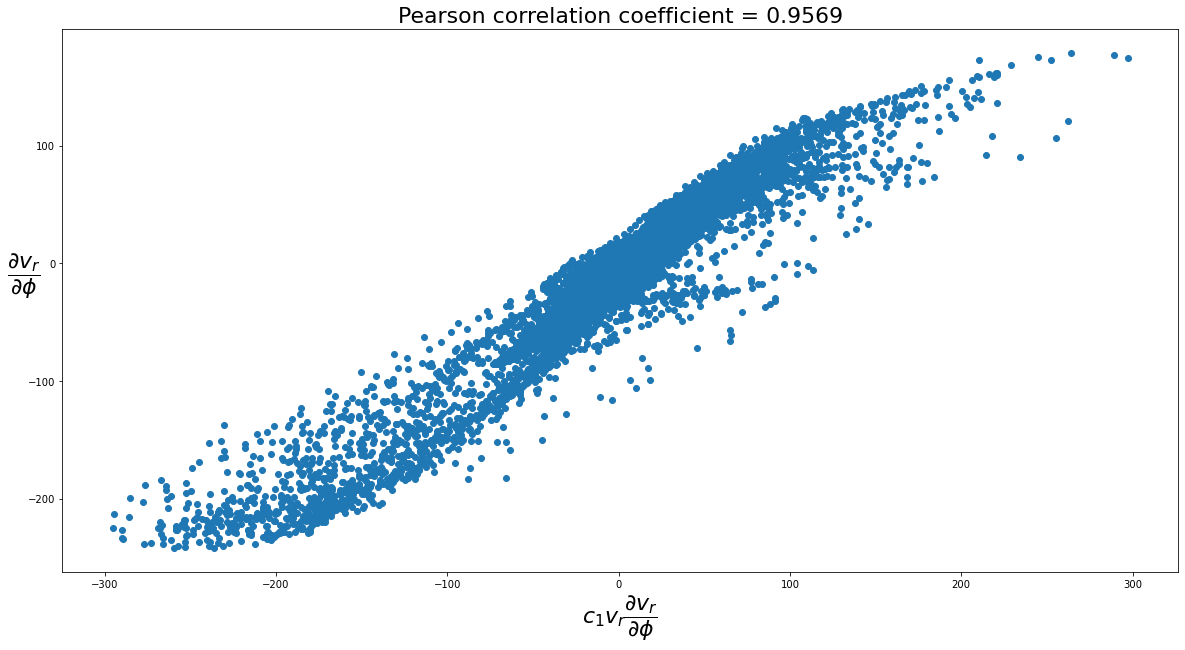

In [89]:
fig, ax = plt.subplots()
_ = ax.scatter(rhs_res_4, lhs)
_ = ax.set_xlabel("$c_{1}v_{r}\dfrac{\partial v_{r}}{\partial \phi}$", fontsize=22)
_ = ax.set_ylabel("$\dfrac{\partial v_{r}}{\partial \phi}$", fontsize=22, rotation=0)
_ = ax.set_title("Pearson correlation coefficient = " + str(round(stats.pearsonr(rhs_res_4, lhs)[0], 4)), fontsize=22)

# Results summary 

The results above validate that the terms $v_{r}\frac{\partial v_{r}}{\partial r}$ and $\frac{1}{\rho} \nabla P$ and $\frac{\partial^2 v_{r}}{\partial \phi^2}$ are the most dominant terms in the library. 


The elements $v_{r}\frac{\partial v_{r}}{\partial r}$ and $\frac{1}{\rho} \nabla P$ originate from the fluid momentum equation in corotating frame of reference:
	
$$
-\Omega_{rot} \frac{\partial v}{\partial \phi} + (v \cdot \nabla)v = \frac{1}{\rho} \nabla P - \frac{G M_{s}}{r^2}e_{r}
$$

On the other hand, $\frac{\partial^2 v_{r}}{\partial \phi^2}$ raises in the modified HUX model, Tunable HUX (THUX), developed by Reiss et al [3]. The resulting PDE for CR 2068 is $\frac{\partial v_{r}}{\partial \phi} =  3.639v_{r}\frac{\partial v_{r}}{\partial r} + 3.2748\frac{1}{\rho} \nabla P -0.334\frac{\partial^2 v_{r}}{\partial \phi^2} $, with pearson coefficient of 0.9826 and mean squared error of 105.196. Whereas, as we increase the damping term in our sparse regression equation ($\lambda$), the coefficents of the diffusion term ($\frac{\partial^2 v_{r}}{\partial \phi^2}$) and pressure ($\partial P/\rho$) from the library vanish, and we are left with the invisicid burger's equation of the form $\frac{\partial v_{r}}{\partial \phi} = 3.399v_{r}\frac{\partial v_{r}}{\partial r}$, with pearson coefficient of 0.9569 and mean squared error of 269.145.

By adding the diffusion term ($\frac{\partial^2 v_{r}}{\partial \phi^2}$) to predict solar wind proton velocity, on average, increases the accurary of our model by less than 1.5%. Repeating this exercise for total of five rotations, produced relative errors of: 0.89, 1.17, 1.25, 1.58, and 0.86% (CR 2050, 2068, 2100, 2170, and 2231), or, an average relative error of 1.15%. Therefore, THUX modification does not have a recognizable contribution to the models accuracy. 

In addition, by adding $\partial P/\rho$ to model solar wind proton velocity, we reduced the model's relative error by 8.65% (CR 2068). Repeating this exercise for total of five rotations, produced relative errors of: 5.8, 8.7, 8.2, 2.9, and 3.1% (CR 2050, 2068, 2075, 2100, 2170, and 2231), or, an average relative error of 5.7%. Given the complexity of including the $\partial P/\rho$ term into the HUX methodology suggests that the modest improvement in accuracy is not worth the cost. 

Hence, the by reducing the fluid momentum equation to the invisicid burgers equation, we are able to capture the most dominant feautres of solar wind stream speed.


![](figures/PDE_FIND_res.png)

<!-- ## Results for several CR datasets: -->


<!-- ![](figures/PDE_FIND_res.png)

After repeating this anaylsis to different Carrington rotation datasets, by average adding $\nabla P$/p term will reduce the model's relative error by 5.4 percent, which is not a significant increase in the model's accuracy. The results agree with Riley's approach which neglects thermal pressure and proton mass density to model solar wind proton streams.  -->